In [1]:
# Add directory above current directory to path
import sys as SYS; SYS.path.insert(0, '..')

# for saving
import os

from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from src import setup
# setup.use_gpu()

from src import ( 
    measurements as measure,
    density_matrix as DM,
    simulation as sim,
    orders,
    order_rules,
    random_unitary,
    simulation)

from Scripts import simulation_CLI as cleo

In [2]:
import sys as SYS; SYS.path.insert(0, '../..')
from Scripts import hdf5merge
hdf5merge.merge_hdf5_files("../data/greedy")

In [3]:
import sys as SYS; SYS.path.insert(0, '../..')
from Scripts import hdf5merge
hdf5merge.merge_hdf5_files("../data/mimic")

In [4]:
import sys as SYS; SYS.path.insert(0, '../..')
from Scripts import hdf5merge
hdf5merge.merge_hdf5_files("../data/landscape_maximizes")

In [5]:
import sys as SYS; SYS.path.insert(0, '../..')
from Scripts import hdf5merge
hdf5merge.merge_hdf5_files("../data/random")

In [6]:
import matplotlib.pyplot as plt 
import matplotlib.animation as animation
# Add directory above current directory to path
import sys as SYS; SYS.path.insert(0, '../..')
import h5py
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from src import ket as ket
from src import density_matrix as DM

In [7]:
newdata1 = dict(h5py.File("../data/random/random.hdf5"))
newdata2 = dict(h5py.File("../data/greedy/greedy.hdf5"))
newdata3 = dict(h5py.File("../data/mimic/mimic.hdf5"))
newdata4 = dict(h5py.File("../data/landscape_maximizes/landscape_maximizes.hdf5"))

In [8]:
def get_pops(data, n_qubits, connectivity,update_rule):
    #dimension 0 is each trial
    #dimension 1 is each time step
    #dimension 2 is each qubit
    result = []
    for trial in data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1']:
        seed = trial.split(' ')[-1]
        dat = dict(data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1'][f'unitary seed {seed}'][f'ordering seed {update_rule}']['pops'])
        dat = {int(k.split('(')[0]): dat[k] for k in dat}
        dat = np.array([np.array([dat[k][subkey][()] for subkey in sorted(dat[k])]) for k in sorted(dat)])
        result.append(dat)
    return(np.array(result))

def get_2_qbit_dms(data, n_qubits, connectivity,update_rule):
    basis = ket.canonical_basis(2)
    #dimension 0 is each trial
    #dimension 1 is each time step (recall that sampling step is 5 by default)
    #dimension 2 is qubit pair
    #dimension 3 and 4 is the 2 qubit density matrix
    result = []
    
    def to_tuple(string):
        tuple_elements = string.strip('()').split(',')
        return tuple(int(elem.strip()) for elem in tuple_elements)

    for trial in data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1']:
        seed = trial.split(' ')[-1]
        dat = dict(data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1'][f'unitary seed {seed}'][f'ordering seed {update_rule}']['two_qubit_dms'])
        dat = {int(k.split('(')[0]): dat[k] for k in dat}
        
        dat = np.array([{to_tuple(subkey):DM.DensityMatrix(dat[k][subkey],basis) for subkey in sorted(dat[k])} for k in sorted(dat)])
        result.append(dat)
    return(np.array(result))

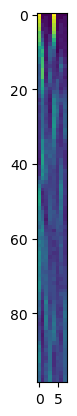

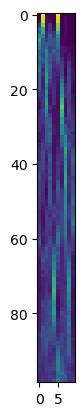

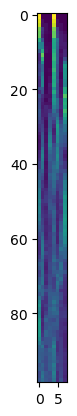

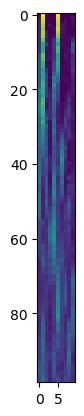

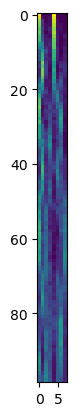

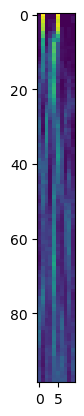

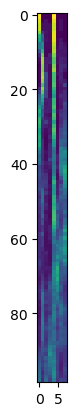

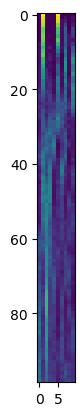

In [9]:
list_conn = ["c4_2local","c5_2local","c6_2local","cN_2local"]
sizes=[8,10]
for conn in list_conn:
    for size in sizes:
        pops = get_pops(newdata1,size,conn,"random")
        for i in range(1):
            plt.imshow(pops[i][0:99], interpolation='none')
            plt.show()

In [31]:
pops = get_pops(newdata4,8,"cN_2local","landscape_maximizes")
pops[0][19]

array([0.3253399 , 0.11779682, 0.01946243, 0.03526776, 0.32769138,
       0.00711742, 0.02037704, 0.1469486 ], dtype=float32)

In [13]:
#MI of every pair
def mutual_info_dicts(twoQdms, trial_index):
    mutual_info_list = []
    for time_step in twoQdms[trial_index]:
        mutual_info_dict = {}
        mutual_info = measure.mutual_information_of_every_pair_dict(time_step)
        # Filter out values below the precision threshold
        filtered_mutual_info = {k: v if v >= 1e-6 else 0 for k, v in mutual_info.items()}
        # Update the mutual_info_dict with the filtered mutual info for the current time step
        mutual_info_dict.update(filtered_mutual_info)
        # Append the mutual_info_dict to the list
        mutual_info_list.append(mutual_info_dict)
    return mutual_info_list

In [14]:
# Call the two_point_dict function for each trial index
# Get the list of dictionaries containing two point values for each time step
def create_adjacency_matrix_two_dim(two_point_dict, num_nodes):
    adjacency_matrix = [[0] * num_nodes for _ in range(num_nodes)]
    for (node1, node2), two_point_value in two_point_dict.items():
        adjacency_matrix[node1][node2] = two_point_value
        adjacency_matrix[node2][node1] = two_point_value  # Assuming undirected graph
    return adjacency_matrix
    
def adjacency_matrices_list_two_dim(twoQdms, trial_index, num_nodes, two_point_dicts):
    # Get the list of dictionaries containing mutual information values for each time step
    two_point_dicts_list = two_point_dicts(twoQdms, trial_index)
    # Create adjacency matrices for each time step
    adjacency_matrices = []
    for two_point_dict in two_point_dicts_list:
        adj_matrix = create_adjacency_matrix_two_dim(two_point_dict, num_nodes)
        adjacency_matrices.append(adj_matrix)
    return adjacency_matrices

In [15]:
twoQdmsrandom=get_2_qbit_dms(newdata4, 10, "cN_2local","landscape_maximizes")
adj_matrix_mi = adjacency_matrices_list_two_dim(twoQdmsrandom,0,10,mutual_info_dicts)

/Users/uja5020/Documents/GitHub/Qnibble/Notebooks/../src/measurements.py:130: RuntimeWarning: divide by zero encountered in log
  from_eigen = -np.sum(eigen_vals * np.log(eigen_vals))
/Users/uja5020/Documents/GitHub/Qnibble/Notebooks/../src/measurements.py:130: RuntimeWarning: invalid value encountered in multiply
  from_eigen = -np.sum(eigen_vals * np.log(eigen_vals))
/Users/uja5020/Documents/GitHub/Qnibble/Notebooks/../src/measurements.py:141: RuntimeWarning: divide by zero encountered in log
  -d4 * np.log(d4) +
/Users/uja5020/Documents/GitHub/Qnibble/Notebooks/../src/measurements.py:141: RuntimeWarning: invalid value encountered in scalar multiply
  -d4 * np.log(d4) +
/Users/uja5020/Documents/GitHub/Qnibble/Notebooks/../src/measurements.py:142: RuntimeWarning: divide by zero encountered in log
  - 0.5 * (b2 + c3 - np.sqrt(b2 ** 2 + 4 * b3 * c2 - 2 * b2 * c3 + c3 ** 2)) * np.log(
/Users/uja5020/Documents/GitHub/Qnibble/Notebooks/../src/measurements.py:142: RuntimeWarning: invalid va

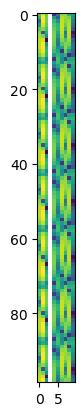

In [19]:
from matplotlib.colors import LogNorm
mi_butterfly =[]
for inde in range(499):
    mi_butterfly.append(adj_matrix_mi[inde][3])

plt.imshow(mi_butterfly[100:199], interpolation='none', norm=LogNorm())
plt.show()

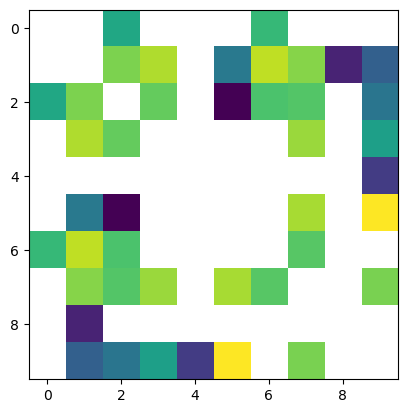

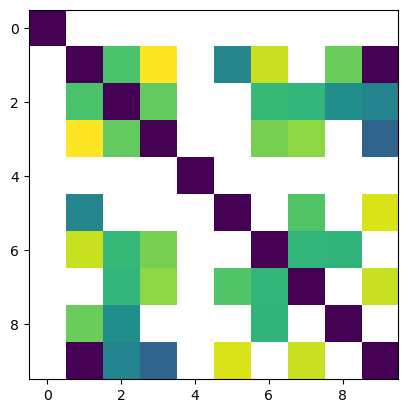

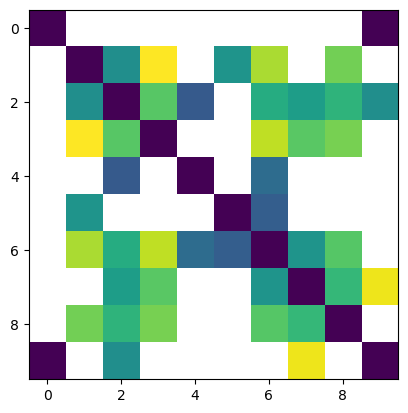

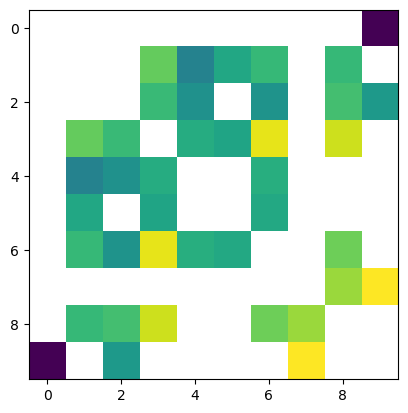

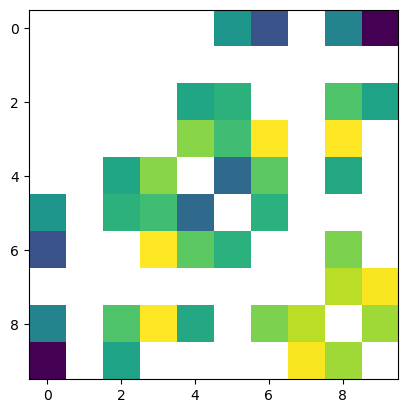

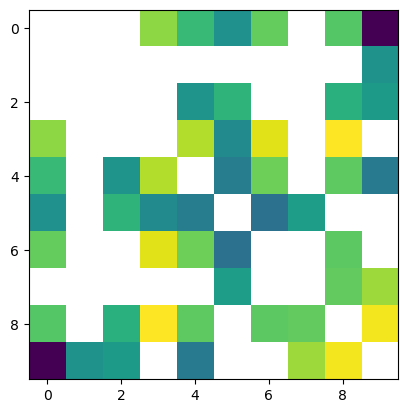

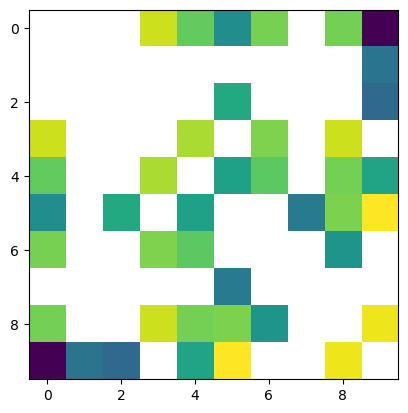

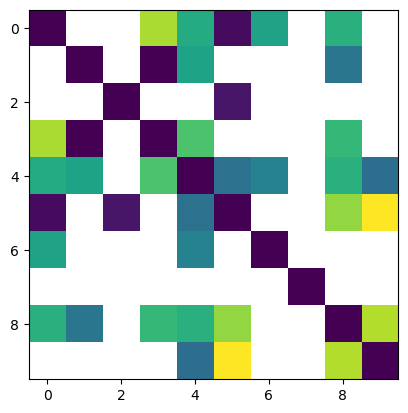

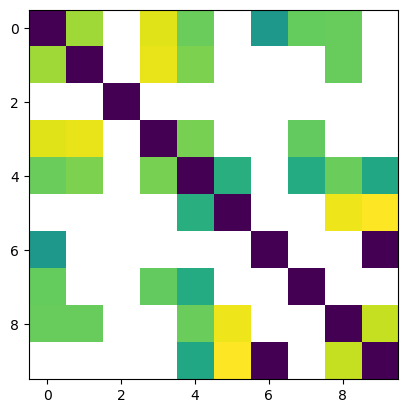

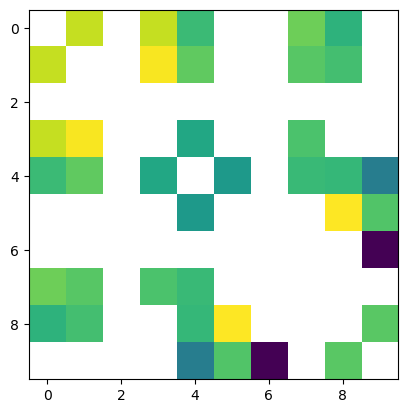

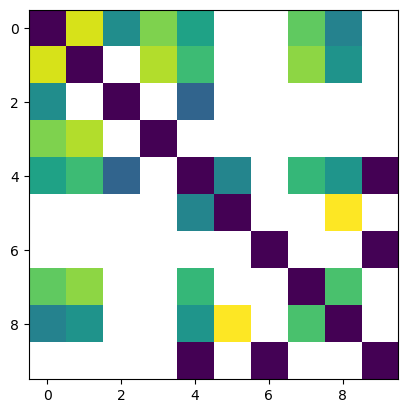

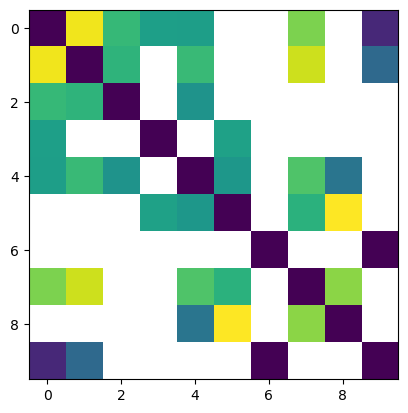

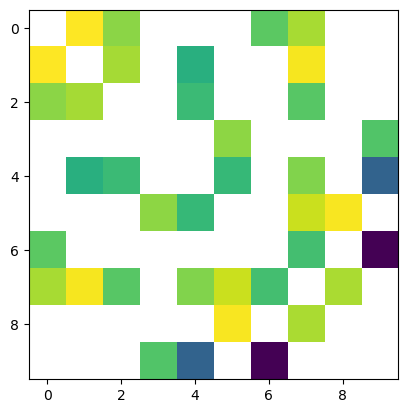

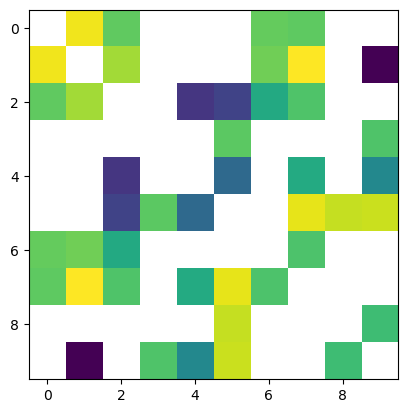

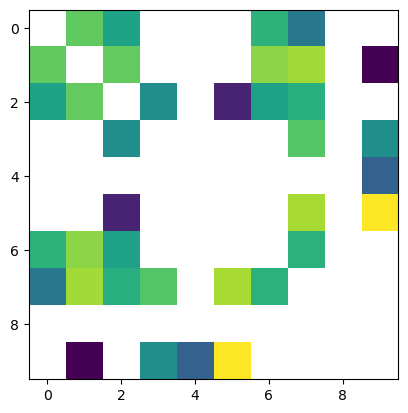

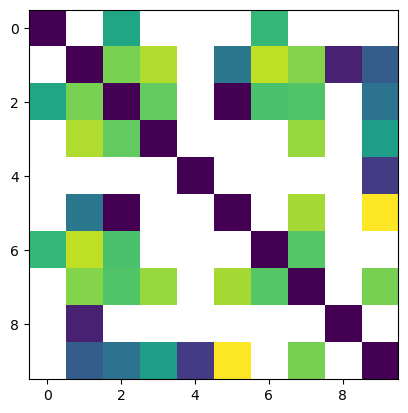

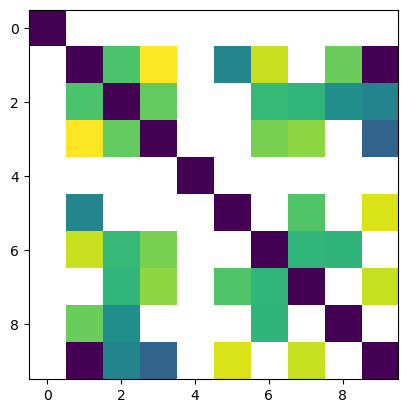

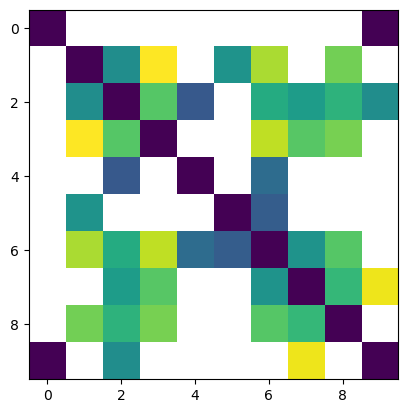

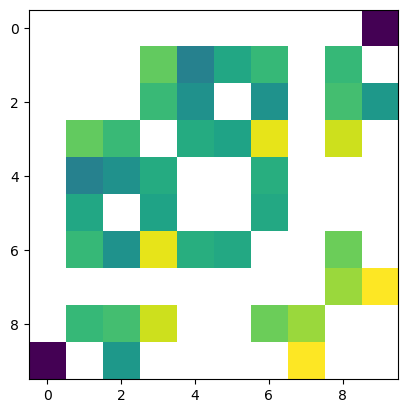

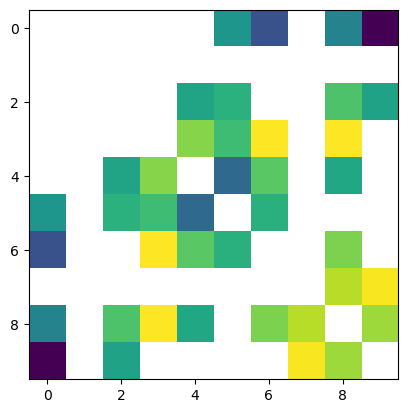

In [20]:
for adj in adj_matrix_mi[400:420]:
    plt.imshow(np.array(adj)-np.array(np.mean(adj_matrix_mi[400:420],axis=0)),norm=LogNorm())
    plt.show()

In [35]:
np.mean(adj_matrix_mi[40:420],axis=0)

array([[0.00000000e+00, 6.95310757e-03, 2.47807695e-03, 1.33469254e-03,
        2.82056831e-04, 1.33570820e-04, 2.29771970e-05, 1.97174538e-05,
        2.51898031e-05, 2.51914300e-05],
       [6.95310757e-03, 0.00000000e+00, 1.68907111e-02, 1.23678387e-03,
        1.30507106e-04, 5.82047038e-05, 1.99628374e-05, 2.29731482e-05,
        2.53408775e-05, 2.53139529e-05],
       [2.47807695e-03, 1.68907111e-02, 0.00000000e+00, 1.11818303e-05,
        6.06223592e-05, 2.97947132e-05, 1.23679136e-03, 1.33469981e-03,
        2.52075623e-05, 2.34972990e-05],
       [1.33469254e-03, 1.23678387e-03, 1.11818303e-05, 0.00000000e+00,
        2.52062504e-05, 2.34947855e-05, 1.68907184e-02, 2.47808054e-03,
        6.06273679e-05, 2.97976746e-05],
       [2.82056831e-04, 1.30507106e-04, 6.06223592e-05, 2.52062504e-05,
        0.00000000e+00, 3.36711881e-05, 2.53457096e-05, 2.52067226e-05,
        3.06877618e-05, 3.06759609e-05],
       [1.33570820e-04, 5.82047038e-05, 2.97947132e-05, 2.34947855e-05,
   